# Startup

In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd "/content/drive/MyDrive/Courses/Fall 2021/dlsys/bnn-cf-vs-robust"

Mounted at /content/drive
/content/drive/MyDrive/Courses/Fall 2021/dlsys/bnn-cf-vs-robust


In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision


In [3]:
# from requirements of https://github.com/hendrycks/robustness/tree/master/ImageNet-C/imagenet_c
# for natural corruptions 
%%capture
!apt install libmagickwand-dev
!pip install numpy Pillow scikit-image Wand opencv-python scipy # most likely only Wand is needed 

# Load raw data

In [4]:
data_raw_path = Path('data/raw')
mnist_data_path = data_raw_path / 'mnist_pytorch'

common_dload_args = dict(
    batch_size = 32,
    num_workers = 4,
    pin_memory = True
)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))
])

In [5]:
mnist_dset_train = torchvision.datasets.MNIST(mnist_data_path, train=True, transform=transform, target_transform=None, download=True)
mnist_train_loader = torch.utils.data.DataLoader(mnist_dset_train, shuffle=True, **common_dload_args)

mnist_dset_test = torchvision.datasets.MNIST(mnist_data_path, train=False, transform=transform, target_transform=None, download=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_dset_test, shuffle=False, **common_dload_args)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


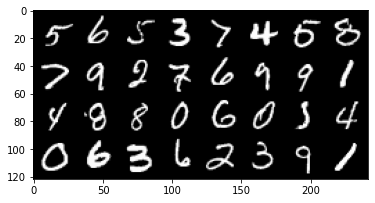

In [6]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(mnist_train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))


# Visualize monochrome corruptions

In [7]:
from src import monochrome_corruptions 

In [8]:
# each of the function in here would take a 2D matrix -> 2D matrix, of vals in [0, 1]
monochrome_corruptions.corruption_collection

{'brightness': <function src.monochrome_corruptions.brightness>,
 'contrast': <function src.monochrome_corruptions.contrast>,
 'defocus_blur': <function src.monochrome_corruptions.defocus_blur>,
 'elastic_transform': <function src.monochrome_corruptions.elastic_transform>,
 'fog': <function src.monochrome_corruptions.fog>,
 'frost': <function src.monochrome_corruptions.frost>,
 'gaussian_blur': <function src.monochrome_corruptions.gaussian_blur>,
 'gaussian_noise': <function src.monochrome_corruptions.gaussian_noise>,
 'glass_blur': <function src.monochrome_corruptions.glass_blur>,
 'impulse_noise': <function src.monochrome_corruptions.impulse_noise>,
 'jpeg_compression': <function src.monochrome_corruptions.jpeg_compression>,
 'motion_blur': <function src.monochrome_corruptions.motion_blur>,
 'pixelate': <function src.monochrome_corruptions.pixelate>,
 'saturate': <function src.monochrome_corruptions.saturate>,
 'shot_noise': <function src.monochrome_corruptions.shot_noise>,
 'snow': 

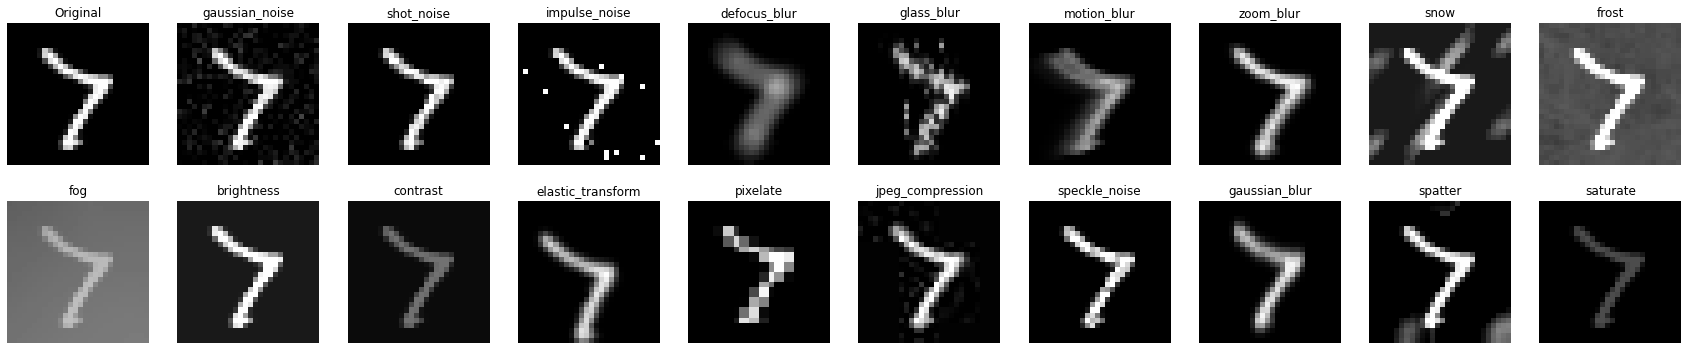

In [9]:
image = images[4].numpy().transpose((1, 2, 0))

fns = list(monochrome_corruptions.corruption_collection.values())
num_cs = len(fns)
ncols = 10
nrows = int(np.ceil((num_cs+1)/ncols))

plt.figure(figsize=(30,6))
plt.subplot(nrows,ncols,1)
plt.imshow(np.squeeze(image), vmin=0, vmax=1, cmap='gray')
plt.title('Original')
plt.axis('off')

for i,fn in enumerate(fns):
    c_img = fn(image.squeeze())
    plt.subplot(nrows,ncols,i+2)
    plt.imshow(c_img, vmin=0, vmax=1, cmap='gray')
    plt.title(fn.__name__)
    plt.axis('off')

# Create directories for o/p-MNIST

This is to avoid transformation computation for corruption

In [10]:
data_inp_path = Path('data/input')
# root_data_path = data_inp_path / 'pmnist_robustness'
root_data_path = data_inp_path / 'pmnist_robustness_test'
# task_sequence = ['MNIST', 'pMNIST', 'pMNIST', 'pMNIST', 'pMNIST', 'pMNIST']
task_sequence = ['MNIST', 'pMNIST', 'pMNIST']

task_metadata = dict(
    task_sequence = task_sequence,
    num_tasks = len(task_sequence),
    root_data = str(root_data_path), 
    task_ids = ['task-%02d' %(i+1) for i in range(len(task_sequence))],
    task_paths = dict()
)

In [11]:
from tqdm.notebook import tqdm
from src.pmnist_robustness_data_utils import create_and_save_datasets, TaskDataSet

In [13]:
# ignore warning about `true_divide`, this was fixed by replacing these inf or nan values with 0 
root_data_path.mkdir(parents=True, exist_ok=True)

subset_mono_natcrpt = {k: v for i, (k,v) in 
                       enumerate(monochrome_corruptions.corruption_collection.items())
                       if i < 2}

                    
perturbation_actions = dict(
    type='corruptions',
    fns=subset_mono_natcrpt
)

task_ids = task_metadata['task_ids']
for i  in tqdm(range(len(task_ids))):
    task_id = task_ids[i]
    task_name = task_metadata['task_sequence'][i]
    perm_dset = 'p' in  task_name

    task_metadata['task_paths'][task_id] = create_and_save_datasets(
        mnist_data_path, 
        root_data_path, 
        task_id, 
        perm=perm_dset, 
        actions=perturbation_actions
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
import yaml 

with open(root_data_path / 'metadata.yaml', 'w') as file:
    documents = yaml.safe_dump(task_metadata, file, default_flow_style=False)


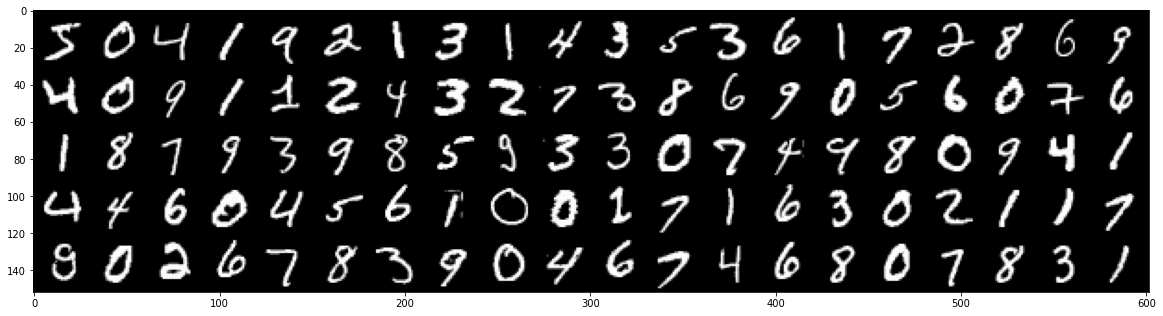

In [15]:
data_prefix = root_data_path / 'task-01' / 'original' / 'train' 
dset = TaskDataSet(data_prefix, transform=transform)
data_loader = torch.utils.data.DataLoader(dset, shuffle=False, batch_size=100)
images, _ = next(iter(data_loader))
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(images, nrow=20))

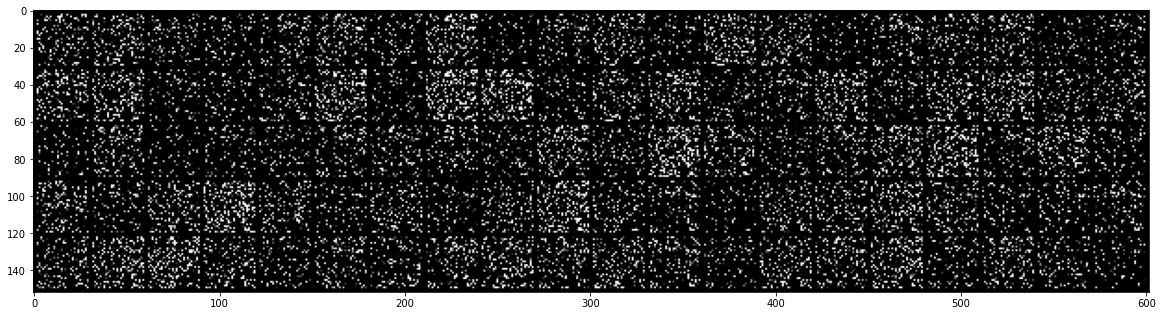

In [16]:
data_prefix = root_data_path / 'task-02' / 'original' / 'train' 
dset = TaskDataSet(data_prefix, transform=transform)
data_loader = torch.utils.data.DataLoader(dset, shuffle=False, batch_size=100)
images, _ = next(iter(data_loader))
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(images, nrow=20))

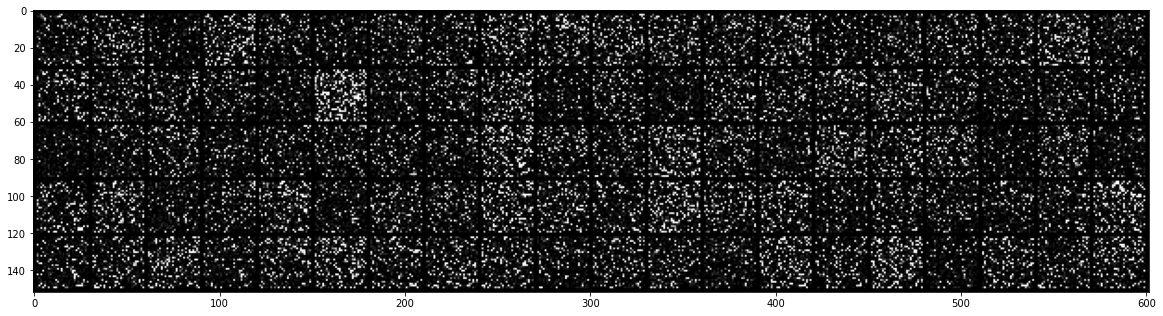

In [17]:
data_prefix = root_data_path / 'task-02' / 'corruptions' / 'gaussian_noise' 
dset = TaskDataSet(data_prefix, transform=transform)
data_loader = torch.utils.data.DataLoader(dset, shuffle=False, batch_size=100)
images, _ = next(iter(data_loader))
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(images, nrow=20))


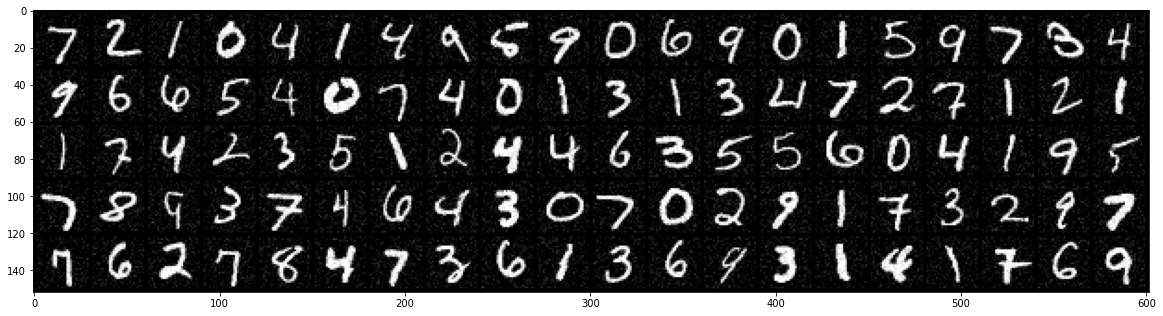

In [18]:
data_prefix = root_data_path / 'task-01' / 'corruptions' / 'gaussian_noise' 
dset = TaskDataSet(data_prefix, transform=transform)
data_loader = torch.utils.data.DataLoader(dset, shuffle=False, batch_size=100)
images, _ = next(iter(data_loader))
plt.figure(figsize=(20,10))
imshow(torchvision.utils.make_grid(images, nrow=20))
